## HU Extension - S89A Deep Learning for NLP - Final Project

### Image Caption Generation - Model Demo
#### Surya Menon

In this file, we use the model created in `model_create.ipynb` to generate captions with some test images. We utilize both greedy and beam searches to generate captions. 

**NOTE:**

We will need the following files in our directory to load:

*  `test_imgs.pkl` - created/saved in `model_create.ipynb`
*  `tokenizer.pkl` - created/saved in `model_create.ipynb`
*  `mod-fin-ep001-loss2.588-val_loss3.214.h5` - created/saved in `model_create.ipynb`
*  `Flicker8k_Dataset` folder - via the `project_data` folder

First we set the maximum caption length to 34, based on what we set in our final model (via training data). Then we load the test images compressed features which we can pass to the model as the image input to create a predicted caption sequence. We previously saved these in `test_imgs.pkl`, when we constructed our network. 

In [1]:
import os 
import keras
import random
import string
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# based on training of model
max_len = 34

# load previous saved test image features
test_imgs = pickle.load(open('test_imgs.pkl', 'rb'))
len(test_imgs)

Using TensorFlow backend.


1000

Next we load our tokenizer (used to pad and index our input/outputs text sequences in the model), and our final model weights, which were again created in `model_create.ipynb`. 

In [2]:
# load saved tokenizer
tokens = pickle.load(open('tokenizer.pkl', 'rb'))

In [3]:
# load final model 
model_name = 'mod-fin-ep001-loss2.588-val_loss3.214.h5'
mod = load_model(model_name)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


We include functions previously used in `model_create.ipynb` to help generate captions. We include the function used to convert the encodings back into their associated words: 

In [4]:
# covert index to word - from model_create.ipynb
def idtw(num, tokens):
    for w, i in tokens.word_index.items():
        if i == num:
            return w
    return None   

We include the function used to create greedy captions: 

In [5]:
# create greedy captions - from model_create.ipynb
def make_cap(model, tokens, img, max_len):
    # start token
    in_txt='<'
    # go over entire possible sequence (of max length)
    for i in range(max_len):
        # encode input - similar set up to generator 
        seq = tokens.texts_to_sequences([in_txt])[0]
        # pad
        seq = pad_sequences([seq], maxlen=max_len)
        # get next word in sequence
        pred = model.predict([np.array(img), seq])
        # get encoded of highest probability
        pred = np.argmax(pred)
        # decode output
        w = idtw(pred, tokens)
        # break if cannot map
        if w is None:
            break
        # append to sequence
        in_txt += ' ' + w
        # stop if reach end token
        if w == '>':
            break
    #txt = in_txt.split()[1:-1]
    #txt = ' '.join(txt)        
    return in_txt 

Also the function to create beam search captions, using different beam indices: 

In [6]:
# create beam search - from model_create.ipynb
def beam_caps(model, tokens, img, max_len, beam_index=3):
    # start sequence
    in_txt = [[tokens.texts_to_sequences(['<'])[0], 0.0]]
   
    # while less than max length
    while len(in_txt[0][0]) < max_len:
        temp = []
        # go through sequence 
        for i in in_txt:
            # pad input sequences
            seq = pad_sequences([i[0]], maxlen=max_len, padding='post')
            # get predictions for next word
            pred = model.predict([np.array(img), seq])
            # sort and pick top beam_index possibilities       
            beam_preds = np.argsort(pred[0])[-beam_index:]

            # create new lists from top picks - words and probabilities
            # incorporate with model prediction
            for w in beam_preds:
                # get current seq, prob
                new_cap, prob = i[0][:], i[1]
                # add word and associated probability 
                new_cap.append(w)
                prob += pred[0][w]
                temp.append([new_cap, prob])

        # hold possibilities 
        in_txt = temp
        # sort probabilities - lambda identifies value
        in_txt = sorted(in_txt, key=lambda p: p[1])
        # pick top in full list of options
        in_txt = in_txt[-beam_index:]

    # pick top word in all
    in_txt = in_txt[-1][0]
    # decode
    inter_cap = [idtw(i, tokens) for i in in_txt]

    # construct caption
    final_cap = []
    for i in inter_cap:
        # if not end token
        if i != '>':
            final_cap.append(i)
        else:
            break

    # take out start token, make string   
    final_cap = ' '.join(final_cap[1:])
    return final_cap

Finally we include the function we created to predict greedy and beam search captions for a specific test set image, plotting the image and printing the results. 

In [7]:
# acquire greedy and beam searches and display an image - from model_create.ipynb
def print_img_caps(path, mod, tokens, img, max_len):
    # plot image
    x= plt.imread(path)  
    plt.imshow(x)
    # reshape image features
    img = img.reshape(1,2048)
    print('\033[1m', 'Image ID:','\033[0m', path.split('\\')[-1])
    # get greedy caption
    txt = make_cap(mod, tokens, img, max_len)[1:-1]
    # get beam searches
    print('Greedy:', txt)
    print('Beam, k=3:', beam_caps(mod, tokens, img, max_len))
    print('Beam, k=5:', beam_caps(mod, tokens, img, max_len, beam_index=5))
    print('Beam, k=7:', beam_caps(mod, tokens, img, max_len, beam_index=7))

We define the path to get access to the actual images in the dataset, in the folder `Flicker8k_Dataset1`. 

In [8]:
# set up full images folder
img_folder = os.path.join(os.getcwd(), 'project_data\Flickr8k_Dataset\Flicker8k_Dataset\\')

# look at image path
img_folder

'C:\\Users\\Surya Menon\\Documents\\python code\\project\\project_data\\Flickr8k_Dataset\\Flicker8k_Dataset\\'

We run the caption generator on a test image to verify it is working:

 Image ID:  3462454965_a481809cea.jpg
Greedy:  black dog is running through the grass 
Beam, k=3: black dog and brown dog are playing in the grass
Beam, k=5: the black dog is running through the grass
Beam, k=7: the black dog is running through the green grass


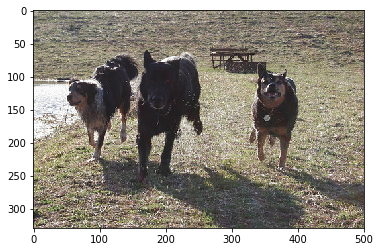

In [9]:
# test image
i ='3462454965_a481809cea.jpg'
path = os.path.join(img_folder, i)
print_img_caps(path, mod, tokens, test_imgs[i.split('.')[0]], max_len)

Next we select 5 random test images to display captions for. We follow this [link](https://stackoverflow.com/questions/10125568/how-to-randomly-choose-multiple-keys-and-its-value-in-a-dictionary-python) to select random keys from our test images dictionary. 

In [10]:
# to reproduce - can take out if want different images
random.seed(8)

# pick 5 random images
keys = random.sample(list(test_imgs), 5)
keys

# Alternative 1 - if know image ids we want, can manually include in list:
# keys = ['3708177171_529bb4ff1d','2718024196_3ff660416a','2167644298_100ca79f54','3502993968_4ee36afb0e','2453971388_76616b6a82']

# Alternative 2 - can get specific images from keys 
# keys = list()
# run 5 (or however many times you want) time - - pick 0-999
# keys.append(list(test_imgs.keys())[100])

['3708177171_529bb4ff1d',
 '2718024196_3ff660416a',
 '2167644298_100ca79f54',
 '3502993968_4ee36afb0e',
 '2453971388_76616b6a82']

We display the results for these selected images below (using this [link](https://forums.fast.ai/t/plotting-images-using-a-for-loop/35009) to loop through images):

 Image ID:  3708177171_529bb4ff1d.jpg
Greedy:  skateboarder in the air 
Beam, k=3: skateboarder doing trick on ramp
Beam, k=5: the skateboarder does trick on ramp
Beam, k=7: the skateboarder does trick on ramp


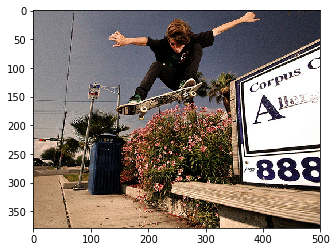


 Image ID:  2718024196_3ff660416a.jpg
Greedy:  young boy in swim trunks is jumping into pool 
Beam, k=3: young boy wearing blue swim trunks is jumping into swimming pool
Beam, k=5: young boy in swim trunks dives into pool
Beam, k=7: young boy in swim trunks jumping into swimming pool


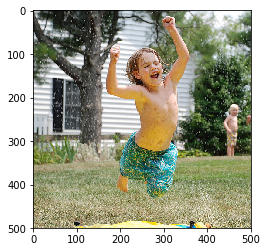


 Image ID:  2167644298_100ca79f54.jpg
Greedy:  man in black shirt and tie is smiling 
Beam, k=3: man and woman wearing black are standing in front of store
Beam, k=5: the man in the black jacket is looking at the camera
Beam, k=7: man and woman pose for picture in front of brick wall


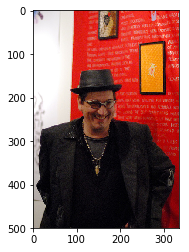


 Image ID:  3502993968_4ee36afb0e.jpg
Greedy:  man in blue shirt and helmet is riding bike on the beach 
Beam, k=3: man on bike is jumping over hill
Beam, k=5: the man is performing trick on bmx bike
Beam, k=7: the man is performing trick on bmx bike


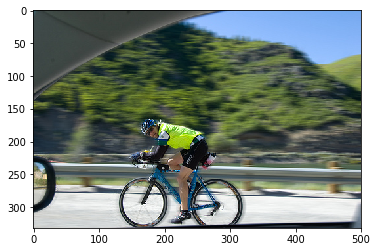


 Image ID:  2453971388_76616b6a82.jpg
Greedy:  boy in swimming trunks is jumping into pool 
Beam, k=3: young boy jumping into swimming pool
Beam, k=5: young boy in swim trunks plays in the water
Beam, k=7: young boy jumping into swimming pool


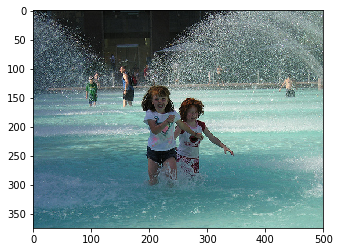

In [11]:
for k in keys:
    img = k + '.jpg'
    path = os.path.join(img_folder, img)
    print_img_caps(path, mod, tokens, test_imgs[img.split('.')[0]], max_len)
    plt.show()
    # add space between images
    print()

If we want to run the model on new or our own images, we first have to pass these images into the `InceptionV3` convolutional neural network (CNN) model to extract features, similar to what was seen in `project_img-features.ipynb`. Then we can run those image features as an input through our model as seen with an image above.